This notebook was created by Donna Faith Go.

In [1]:
# import sys
# !{sys.executable} -m pip install arch

In [2]:
# standard imports
import matplotlib.pyplot as plt
import pandas as pd 
import pickle
import numpy as np
import seaborn as sns
from typing import Tuple

# data gathering
import yfinance as yf

# statsmodels
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.stattools import adfuller, kpss

# GARCH model
from arch import arch_model

# topological data analysis
from ripser import Rips
import persim
from persim.landscapes import PersLandscapeExact, PersLandscapeApprox
from persim.landscapes import plot_landscape_simple

# ignore warnings
import warnings
warnings.filterwarnings("ignore", category=FutureWarning)

# GARCH on the PSEi

This notebook aims to do volatility clustering on the Philippine Stock Exchange Composite Index (PSEi) through the Generalized Autoregressive Conditional Heteroskedasticity (GARCH) model.

## Data Gathering

In [3]:
# getting closing prices for the 30 stocks with batching
start_date = '2013-01-01'# '2019-01-01'
end_date = '2026-01-01' #'2025-08-01'

def download_stocks_in_batches(tickers, batch_size=5, delay=1):
    """
    Download stock data in batches to avoid rate limiting
    """
    all_data = {}
    
    for i in range(0, len(tickers), batch_size):
        batch = tickers[i:i + batch_size]
        print(f"Downloading batch {i//batch_size + 1}: {batch}")
        
        try:
            # Download the batch
            batch_data = yf.download(
                batch,
                start=start_date,
                end=end_date,
                progress=False
            )
            
            # Extract closing prices for this batch
            if not batch_data.empty and 'Close' in batch_data.columns:
                closes = batch_data['Close']
                if isinstance(closes, pd.Series):
                    all_data[batch[0]] = closes
                else:
                    for ticker in closes.columns:
                        all_data[ticker] = closes[ticker]
                print(f"Successfully downloaded {len(batch)} stocks")
            else:
                print(f"No data returned for batch: {batch}")
            
        except Exception as e:
            print(f"Error downloading batch {batch}: {e}")
        
        # Add delay to avoid rate limiting
        if i + batch_size < len(tickers):
            print(f"Waiting {delay} seconds before next batch...")
            time.sleep(delay)
    
    if all_data:
        return pd.DataFrame(all_data)
    else:
        return pd.DataFrame()

# # Download in batches of 5 stocks with 1-second delay
# closing_df = download_stocks_in_batches(
#     ['^VIX'], 
#     batch_size=5, 
#     delay=5
# )

# if not closing_df.empty:
#     closing_df.to_pickle('VIX data.pkl')

In [4]:
filepath = r'psei closing prices.pkl'
with open(filepath, 'rb') as f:
    pse_data = pickle.load(f)

# pse_data = pse_data.loc[pd.Timestamp('2025-01-01'):]
print(pse_data.index[0])
print(pse_data.index[-1])

2013-01-02 00:00:00
2025-12-29 00:00:00


## Data Preprocessing

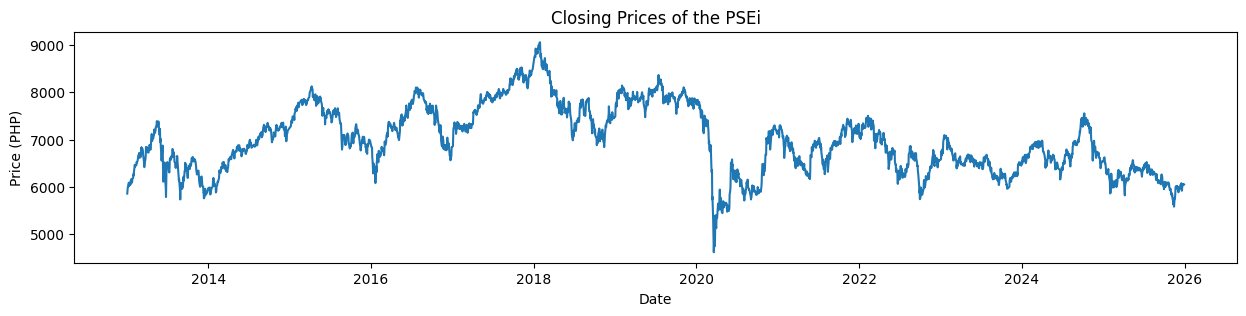

In [5]:
# plot the closing prices of the PSEi
plt.figure(figsize=(15, 3))
plt.plot(pse_data)
plt.xlabel('Date')
plt.ylabel('Price (PHP)')
plt.title('Closing Prices of the PSEi')
plt.show()

The data does not look stationary.

In [6]:
# get log returns
tau_val = 5
log_returns = np.log(pse_data['PSEI.PS']).diff(tau_val).dropna()
simple_returns = 100 * pse_data.pct_change().dropna()
pse_data_volatility = log_returns.rolling(window=2).std()

C:\Users\Donna\AppData\Local\Temp\ipykernel_6752\1404364965.py:4: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  kpss_res = kpss(log_returns)[1]


ADF Result: Stationary
KPSS Result: Stationary


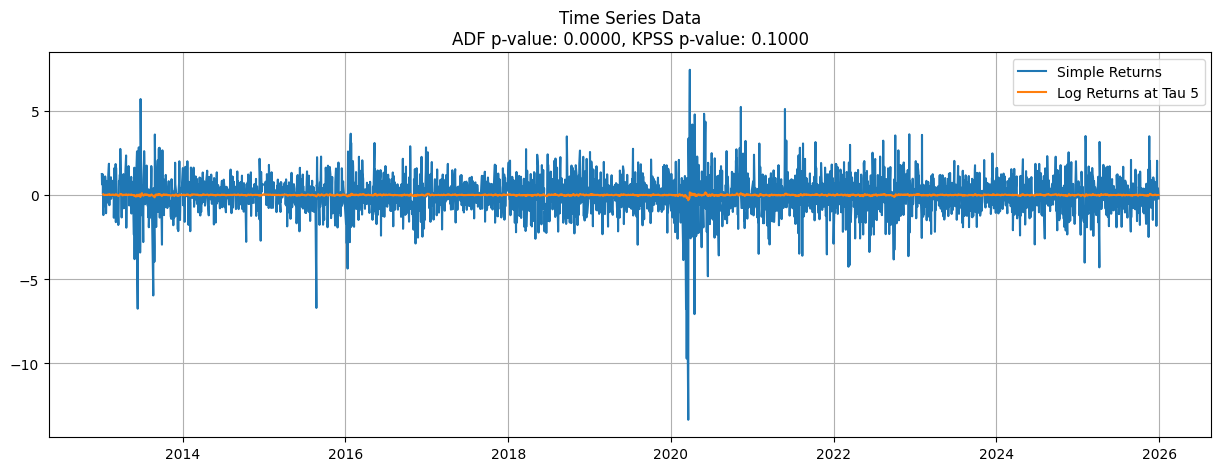

In [7]:
# checking for stationarity
p_value = 0.05
adf_res = adfuller(log_returns)[1]
kpss_res = kpss(log_returns)[1]

print("ADF Result:", "Stationary" if adf_res < p_value else "Not Stationary")
print("KPSS Result:", "Stationary" if kpss_res > p_value else "Not Stationary")

# plotting
plt.figure(figsize=(15, 5))
plt.plot(simple_returns, label='Simple Returns')
plt.plot(log_returns, label=f'Log Returns at Tau {tau_val}')
plt.title(f"Time Series Data\nADF p-value: {adf_res:.4f}, KPSS p-value: {kpss_res:.4f}")
plt.grid(True)
plt.legend()
plt.show()

## GARCH
Read from [this link](https://phychai.wordpress.com/2017/05/08/conditional-volatility-from-garch-vs-vix/).

In [8]:
# creating the model
model = arch_model(log_returns, p=1, q=1, hold_back=10)
model_fit = model.fit()

Iteration:      1,   Func. Count:      6,   Neg. LLF: 130088956830.07657
Iteration:      2,   Func. Count:     19,   Neg. LLF: 1026973498.8225367
Iteration:      3,   Func. Count:     31,   Neg. LLF: 3350478282.2440815
Optimization terminated successfully    (Exit mode 0)
            Current function value: -7731.227889077625
            Iterations: 4
            Function evaluations: 41
            Gradient evaluations: 3


C:\Users\Donna\AppData\Local\Programs\Python\Python312\Lib\site-packages\arch\univariate\base.py:694: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.000698. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  self._check_scale(resids)


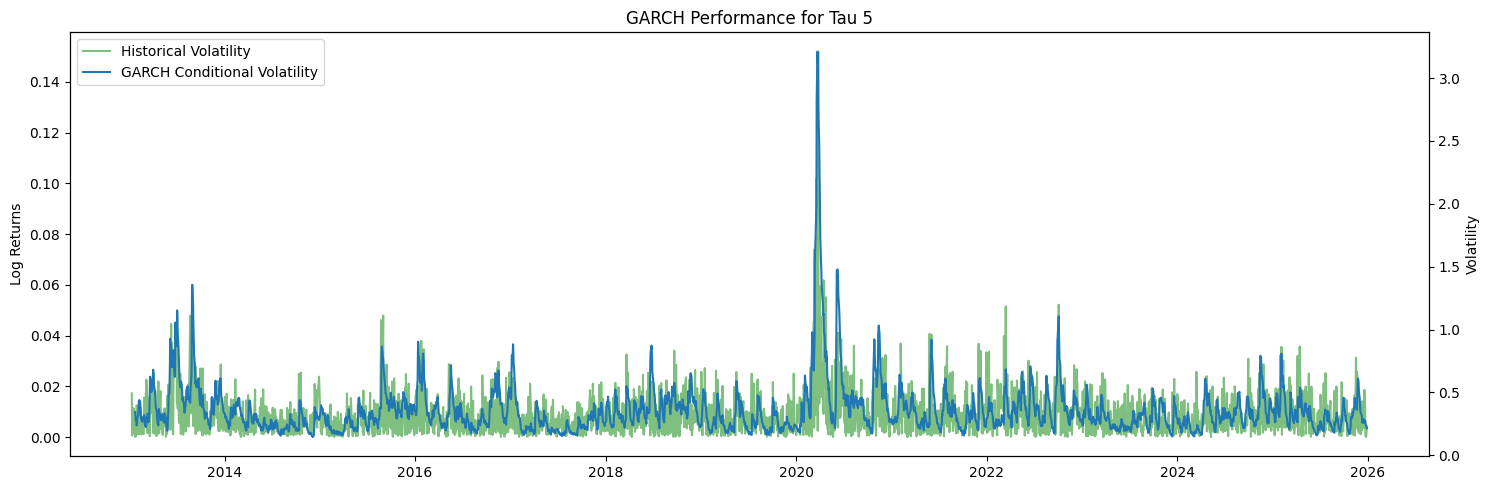

In [9]:
# predictions
cond_vol = np.sqrt(250.)*model_fit.conditional_volatility

# plotting
plt.figure(figsize=(15, 5))

ax1 = plt.gca()
ax1.plot(pse_data_volatility, label='Historical Volatility', c='g', alpha=0.5)
# ax1.plot(pse_data, label='PSE', c='g')
ax1.set_ylabel('Log Returns')

ax2 = ax1.twinx()
ax2.plot(cond_vol, label='GARCH Conditional Volatility')
ax2.set_ylabel('Volatility')

plt.title(F'GARCH Performance for Tau {tau_val}')
lines_1, labels_1 = ax1.get_legend_handles_labels()
lines_2, labels_2 = ax2.get_legend_handles_labels()
ax1.legend(lines_1 + lines_2, labels_1 + labels_2, loc='upper left')
plt.tight_layout()
plt.show()

## Gidea and Katz

### Embed to 50 dimensions

In [10]:
def create_xy(series: pd.Series, lookback: int = 12, horizon: int = 1) -> Tuple[np.ndarray, np.ndarray]:
    """Create the X and y arrays from a pd.Series object. The `lookback`
    determines the number of features we would include in X. While the
    `horizon` paramter informs us how many points we'll need to forecast.

    Paramters:
    ----------
    series (pd.Series): the (n, 1) time series to be sliced into X and Y
    lookback (int): the lookback window to consider (default=12)
    horizon (int): the number of points to forecast for each row in X (default=1)

    Returns:
    -------
    (X, y) (Tuple): a tuple of ndarrays
    """
    x = []
    y = []
    
    series_size = series.shape[0]
    for i in range(series_size):
        
        # break loop if series is less than the required time horizon
        if series.iloc[(i + lookback): (i + lookback + horizon)].shape[0] < horizon:
            break
        x.append(
            series.iloc[i: (i + lookback)]
        )
        y.append(
            series.iloc[(i + lookback): (i + lookback + horizon)]
        )
    x = np.dstack(x)
    y = np.dstack(y)

    # Reshape x to (samples, features, lookback)
    x = np.swapaxes(x, 0, 2)
    # Then flatten (samples, features * lookback)
    x = x.reshape(x.shape[0], x.shape[1] * x.shape[2])

    # Reshape y tp (samples, horizon)
    y = np.swapaxes(y, 0, 2)
    y = y[:, :, 0]


    
    return x, np.array(y).flatten()

In [11]:
train, test = create_xy(log_returns, 50, 1)
print(train.shape)
print(test.shape)

(3110, 50)
(3110,)


In [12]:
train

array([[ 0.0385233 ,  0.0141427 ,  0.0133577 , ..., -0.02656817,
        -0.0416191 , -0.05453235],
       [ 0.0141427 ,  0.0133577 ,  0.0080717 , ..., -0.0416191 ,
        -0.05453235, -0.05411066],
       [ 0.0133577 ,  0.0080717 ,  0.00638901, ..., -0.05453235,
        -0.05411066, -0.03368105],
       ...,
       [-0.0117021 ,  0.00863056, -0.00125162, ...,  0.006901  ,
        -0.01937744, -0.00277046],
       [ 0.00863056, -0.00125162, -0.00076112, ..., -0.01937744,
        -0.00277046, -0.00227649],
       [-0.00125162, -0.00076112,  0.00596987, ..., -0.00277046,
        -0.00227649, -0.00220342]], shape=(3110, 50))

### L1 and L2 Norms

As far as I know, we cannot get a persistence diagram from just one stock because it wouldn't work for the first step, Rips filtration. 
Hence, I will just get the L1 and L2 norm for every window with numpy.

In [13]:
print(train.shape)
print(log_returns[:len(train)].shape)

(3110, 50)
(3110,)


In [14]:
# get the norms
l1_norms = []
l2_norms = []
dates = log_returns[train.shape[1]:].index
for i in range(len(train)):
    l1 = np.linalg.norm(train[i], ord=1)
    l2 = np.linalg.norm(train[i], ord=2)
    l1_norms.append(l1)
    l2_norms.append(l2)

# plot the landscapes
plt.figure(figsize=(15, 5))
plt.plot(dates, l1_norms, label='L1 Norms')
plt.plot(dates, l2_norms, label='L2 Norms')
plt.ylim(0, 10)

title = f'L1 and L2 Norms of the PSEi with Lag {tau_val}'
plt.title(title)
plt.legend()
plt.tight_layout()
plt.savefig(f'figures/{title}.png')
plt.close()

### Results: L1 and L2 Norms

The figures below show that there is a clear peak in the L1 and L2 norms during the covid pandemic, specifically at the start of 2020. This is consistent across different time lags. 
As evidently shown, the bigger the time lag, the clearer (or more distinguishable) the peak in the L1 and L2 norm.
This entails that there was significant change in the market structure of the PSEi that was reflected in the PSEi during the onset of the COVID-19 crisis.
This change could be due to market instability due to its context, or other factors. 

<div align="center">
    <img src="figures/L1 and L2 Norms of the PSEi with Lag 5.png" style="width:70%;" />
    <img src="figures/L1 and L2 Norms of the PSEi with Lag 10.png" style="width:70%;" />
    <img src="figures/L1 and L2 Norms of the PSEi with Lag 21.png" style="width:70%;" />
</div>


### Lp Norms and the CBOE Volatility Index (^VIX)

In [15]:
filepath = r'VIX data.pkl'
with open(filepath, 'rb') as f:
    vix_data = pickle.load(f)

In [16]:
# plot the landscapes and VIX
fig, ax1 = plt.subplots(figsize=(15, 5))
ax1.plot(dates, l1_norms, label="L1 Norms")
ax1.plot(dates, l2_norms, label="L2 Norms")
ax1.set_xlabel("Date")
ax1.set_ylabel("Lp Norms")
ax1.set_ylim(0, 10)

ax2 = ax1.twinx()
ax2.plot(
    vix_data.index, vix_data.values, label="VIX", 
    alpha=0.3, color='green', linestyle='-.'
)
ax2.set_ylabel("VIX")

# Combine legends
lines_1, labels_1 = ax1.get_legend_handles_labels()
lines_2, labels_2 = ax2.get_legend_handles_labels()
ax1.legend(lines_1 + lines_2, labels_1 + labels_2, loc="upper right")

title = f'Lp Norms and VIX with Lag {tau_val}'
plt.title(title)
plt.tight_layout()
plt.savefig(f'figures/{title}.png')
plt.close()

### Results: Comparison with VIX

Compared to the VIX, it is clear that the L2 norms can somewhat be an accurate measure of the volatility in the market during periods of clear financial crashes.
During other periods, it seems to not predict it as well enough, or it might need other methods of outlier detection to determine if there truly is a financial crash occurring during that period. 
It must be noted that it also seems that the L2 norms have somewhat of a lag in reaction to periods of financial crashes (see the peak during COVID and compare the VIX to the L2 Norms).

<div align="center">
    <img src="figures/Lp Norms and VIX with Lag 5.png" style="width:90%;" />
    <img src="figures/Lp Norms and VIX with Lag 10.png" style="width:90%;" />
    <img src="figures/Lp Norms and VIX with Lag 21.png" style="width:90%;" />
</div>


## Appendix

This section contains code that was created but not used and other personal notes that I want to keep for myself.

In [17]:
def get_norms(data):
    # get the persistence landscape
    rips = Rips(maxdim=1)
    dgms_pd = rips.fit_transform(data)
    pl = PersLandscapeApprox(dgms=dgms_pd, hom_deg=1)
    
    # get the L1 and L2 norms
    l1_norm = pl.pl_norm(1)
    l2_norm = pl.pl_norm(2)
    return l1_norm, l2_norm

### Personal Notes

**Different Tau Values**
1. Tau value of 1: There is little signal that is captured by the PACF and ACF graphs.
2. Tau value of 2 5 onwards: There is more signal that is captured, but it differs for the different lags.